In [1]:
# First we have to comunicate to notebook
# that we want to use matplotlib animations
%matplotlib notebook

In [2]:
# Importing libraries
import numpy as np

# Importing ros libraries
import rospy
import actionlib
import tf
from tf.transformations import quaternion_matrix

# Importing needed messages and actions
from actionlib_msgs.msg import GoalStatus
from move_base_msgs.msg import MoveBaseAction, MoveBaseActionGoal, MoveBaseGoal
from geometry_msgs.msg import Twist
from sensor_msgs.msg import LaserScan
from nav_msgs.msg import Odometry

# Importing widgets
import ipywidgets as widgets
from ipywidgets import Button, ButtonStyle, Layout, HBox, VBox, Output, BoundedFloatText, Text, GridBox

# Importing matplotlib library
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.ticker import MaxNLocator

In [3]:
class RobotController:
    # If the user requested collision avoidance assitance
    assistance = False
    # The last recorded robot velocity (corrected by the collision avoidance)
    last_vel = Twist()
    
    #An ActionClient used to send commands to the move_base ActionServer
    move_client = actionlib.SimpleActionClient("move_base", MoveBaseAction)
    # A publisher to the 'cmd_vel' topic to move the robot
    vel_pub = rospy.Publisher("cmd_vel", Twist, queue_size=10)
    
    def __init__(self):
        # A subscriber to the 'scan' topic to get the laser scanner data
        rospy.Subscriber("scan", LaserScan, self.on_laser_scan)
        
    # -------------------------- AUTOMATIC DRIVE SECTION --------------------------
    
    # Sets a target position (x, y) to the move_base server
    def set_specific_goal(self, x, y):
        # Waiting until server exists
        self.move_client.wait_for_server()
        # Creating the goal containing the target position
        goal = MoveBaseGoal()
        goal.target_pose.header.frame_id = "map"
        goal.target_pose.pose.orientation.w = 1
        goal.target_pose.pose.position.x = x
        goal.target_pose.pose.position.y = y
        # Communicating the goal to the server
        self.move_client.send_goal(goal)
        # Printing a log on the 'log' output
        with log: print("A new target has been set to the move_base action server.") 

    # Cancels the current goal (if existing)
    def cancel_specific_goal(self):
        # Checking if a goal has previously been set
        if self.move_client.get_state() == GoalStatus.LOST :
            with log: print("No target is currently set on the move_base action server.")
            return
        # Removing previously set goal
        self.move_client.cancel_goal()
        # Printing a log on the 'log' output
        with log: print("The previous target has been cleared.")
            
    # -------------------------- MANUAL DRIVE SECTION --------------------------
    
    # Inits the manual drive logic
    def start_manual_drive(self, assistance):
        # Storing the assistance value
        self.assistance = assistance
        # Cancelling all goals to be sure move_base is stopped
        self.move_client.cancel_all_goals()

    # Sets a velocity to the robot
    def set_manual_velocity(self, linear, angular):
        # Creating the desired velocity
        self.last_vel = Twist()
        self.last_vel.linear.x = linear;
        self.last_vel.angular.z = angular;
        # Publishing desired velocity
        self.vel_pub.publish(self.last_vel)

    # Callback function that is called when the robot scans the environment
    def on_laser_scan(self, scans):
        # There is no need to avoid collision if robot is not moving
        if self.last_vel.linear.x == 0 or self.last_vel.angular.z == 0 :
            return
        
        # Dividing the scans into 3 directions: LEFT, FRONT, RIGHT
        clear_directions = [
            min(scans.ranges[  0:287]) > 0.3,
            min(scans.ranges[288:431]) > 0.3,
            min(scans.ranges[432:720]) > 0.3,
        ]

        # Checking if the next movement would cause a collision and prevent it
        corrected = False
        if self.last_vel.linear.x > 0 and not clear_directions[1] :
            self.last_vel.linear.x = 0
            corrected = True
        if self.last_vel.angular.z > 0 and not clear_directions[2] :
            self.last_vel.angular.z = 0
            corrected = True
        if self.last_vel.angular.z < 0 and not clear_directions[0] :
            self.last_vel.angular.z = 0
            corrected = True

        if corrected :
            # Publishing corrected velocity
            self.vel_pub.publish(self.last_vel)  
            # Printing a log on the 'log' output
            with log: print("A collision has been avoided!") 

In [4]:
class Menu:
    # Creating container for menu controls
    menu_controls = HBox(layout=Layout(width='auto', height='auto', border='1px solid black', grid_area='c'))
    # Creating container for the user actions
    menu_actions = VBox(layout=Layout(width='auto', height='auto', border='1px solid black', grid_area='a'))
    # Creating container for the output log
    log = Output(layout=Layout(width='auto', height='auto', border='1px solid black', grid_area='l'))
        
    # Actually creating the menu that will be displayed
    menu = GridBox(children=[menu_controls, menu_actions, log], 
                   layout=Layout(width='100%',height='500px',
                                 border='1px solid black',
                                 grid_template_columns='40% auto', grid_template_rows='10% auto',
                                 grid_template_areas=''' "c l"
                                                         "a l" '''))
    
    def __init__(self, controller):
        # Storing the controller
        self.controller = controller
        # Initializing the menu as the main menu
        self.show_main_menu()
    
    def show_main_menu(self):
        # A generic button layout
        btn_layout = Layout(width='auto', height='25%')
        # Creating buttons for automatic drive to target
        b1 = Button(description='DRIVE AUTONOMOUSLY TO SPECIFIC TARGET', layout=btn_layout)
        b1.on_click(lambda b : self.show_x_y_menu())
        # Creating button for removing the current target
        b2 = Button(description='STOP DRIVING TO SPECIFIC TARGET', layout=btn_layout)
        b2.on_click(lambda b : self.controller.cancel_specific_goal())
        # Creating button for manual drive without assitance
        b3 = Button(description='DRIVE MANUALLY WITHOUT ASSISTANCE', layout=btn_layout)
        b3.on_click(lambda b : (self.controller.start_manual_drive(False), self.show_controls_menu()))
        # Creating button for manual drive with assistance
        b4 = Button(description='DRIVE MANUALLY WITH ASSISTANCE', layout=btn_layout)
        b4.on_click(lambda b : (self.controller.start_manual_drive(True), self.show_controls_menu()))
        # Creating the menu
        self.menu_controls.children = ()
        self.menu_actions.children = (b1, b2, b3, b4)

    def show_x_y_menu(self):
        # Creating special text input only for float parameters
        x_text = BoundedFloatText(value=0, min=-20.0, max=20.0, step=0.001, description='Target X:')
        y_text = BoundedFloatText(value=0, min=-20.0, max=20.0, step=0.001, description='Target Y:')
        # Creating target position confirm button
        confirm_btn = Button(description='CONFIRM', layout=Layout(width='25%', height='80px'))
        confirm_btn.on_click(lambda b : (
            self.controller.set_specific_goal(x_text.value, y_text.value),
            self.show_main_menu()
        ))
        # Creating button for returning to the main menu
        back_btn = Button(description='<', layout=Layout(width='20%', height='auto'))
        back_btn.on_click(lambda b : (self.controller.set_manual_velocity(0, 0), self.show_main_menu()))
        # Creating the menu
        self.menu_controls.children = (back_btn,)
        self.menu_actions.children = (x_text, y_text, confirm_btn)

    def show_controls_menu(self):
        # Creating button for moving manually the robot
        f_btn = Button(description='FORWARD', layout=Layout(width='100%', height='100%', grid_area='f'))
        f_btn.on_click(lambda b : self.controller.set_manual_velocity(0.4, 0))
        b_btn = Button(description='BACKWARD', layout=Layout(width='100%', height='auto', grid_area='b'))
        b_btn.on_click(lambda b : self.controller.set_manual_velocity(-0.4, 0))
        l_btn = Button(description='LEFT', layout=Layout(width='100%', height='100%', grid_area='l'))
        l_btn.on_click(lambda b : self.controller.set_manual_velocity(0, 0.4))
        r_btn = Button(description='RIGHT', layout=Layout(width='100%', height='100%', grid_area='r'))
        r_btn.on_click(lambda b : self.controller.set_manual_velocity(0, -0.4))
        s_btn = Button(description='STOP', layout=Layout(width='100%', height='100%', grid_area='s'))
        s_btn.on_click(lambda b : self.controller.set_manual_velocity(0, 0))
        # Creating a GridBox to organize the buttons
        grid = GridBox(children=[f_btn, b_btn, l_btn, r_btn, s_btn],
                       layout=Layout(width='100%', height='50%', 
                                     grid_template_rows='auto auto auto', 
                                     grid_template_columns='33% 33% 33%',
                                     grid_template_areas=''' " . f . "
                                                             " l s r "
                                                             " . b . " '''))
        # Creating button for returning to the main menu
        # This button reset any residual velocity the robot may have
        back_btn = Button(description='<', layout=Layout(width='20%', height='auto'))
        back_btn.on_click(lambda b : (self.controller.set_manual_velocity(0, 0), self.show_main_menu()))
        # Creating the menu
        self.menu_controls.children = (back_btn,)
        self.menu_actions.children = (grid,)

In [5]:
# Initializing node to be able to use ros functionalities
# This needs to be called once per process
rospy.init_node("robot_notebook_ui")

# The robot controller node which interacts with the ros interface
robot_controller = RobotController()
# The menu which called the robot_controller functionalities
controller_menu = Menu(robot_controller)

# Making the controller_menu.log global
log = controller_menu.log

In [6]:
display(controller_menu.menu)

GridBox(children=(HBox(layout=Layout(border='1px solid black', grid_area='c', height='auto', width='auto')), V…

In [7]:
class ScannerVisualizer:
    def __init__(self):
        # Creating a figure with only one subplot
        self.fig, self.ax = plt.subplots()
        # A plot with red (r) cirlce (o) markers and data
        self.plot, = plt.plot([], [], 'ro')
        # Setting some informations on the graph
        plt.title("Robot Scanner Visualizer")
        plt.xlabel('Cone of vision (Degrees)')
        plt.ylabel('Distance (Meters)')
        
        # The data on the x_axis can already be created
        self.x_data = np.arange(-90, 90, 0.25)
        
        # A subscriber to the 'scan' topic to get the laser scanner data
        rospy.Subscriber("scan", LaserScan, self.on_laser_scan)
        
    def plot_init(self):
        self.ax.set_xlim(90, -90)
        self.ax.set_ylim(0, 15)
        return self.plot
    
    def on_laser_scan(self, scans):
        # Storing the current scands data to able to create graph
        self.y_data = np.asarray(scans.ranges)

    def update_plot(self, frame):
        # Creating the data
        self.plot.set_data(self.x_data, self.y_data)
        return self.plot

<IPython.core.display.Javascript object>


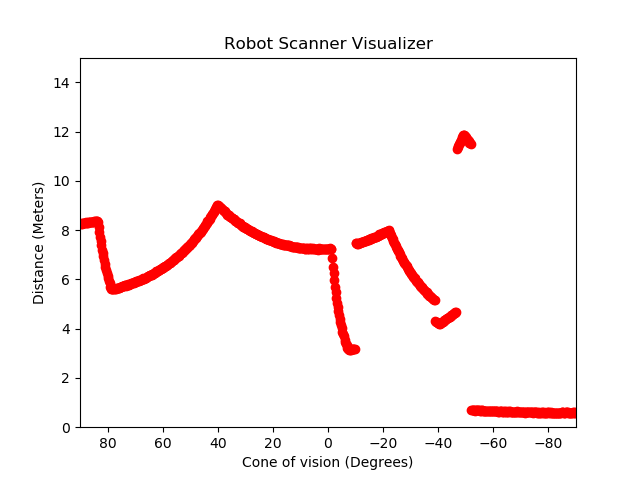

In [8]:
# Creating, displaying and animating the scanner visualizer
scan_visualizer = ScannerVisualizer()
anim0 = FuncAnimation(scan_visualizer.fig, scan_visualizer.update_plot, init_func=scan_visualizer.plot_init)

In [9]:
class PositionVisualizer:
    def __init__(self):
        # Creating a figure with only one subplot
        self.fig, self.ax = plt.subplots()
        # A plot with red (r) cirlce (o) markers and data
        self.plot, = plt.plot([], [], 'ko')
        # Setting some informations on the graph
        plt.title("Robot Position Visualizer")
        plt.xlabel('X position (Meters)')
        plt.ylabel('Y position (Meters)')
        
        # These will contain the positions of the robot
        self.x_data, self.y_data = [] , []
        
        # Subscribing to the 'odom' topic to receive robot position
        rospy.Subscriber('/odom', Odometry, self.odom_callback)
        
    def plot_init(self):
        self.ax.set_xlim(-10, 10)
        self.ax.set_ylim(-10, 10)
        return self.plot

    def odom_callback(self, odom):
        self.y_data.append(odom.pose.pose.position.y)
        self.x_data.append(odom.pose.pose.position.x)

    def update_plot(self, frame):
        self.plot.set_data(self.x_data, self.y_data)
        return self.plot

<IPython.core.display.Javascript object>


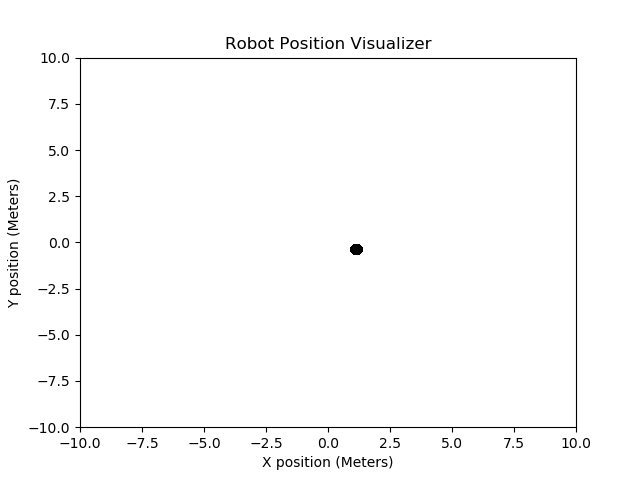

In [10]:
# Creating, displaying and animating the position visualizer
pos_visualizer = PositionVisualizer()
anim1 = FuncAnimation(pos_visualizer.fig, pos_visualizer.update_plot, init_func=pos_visualizer.plot_init)

In [11]:
class TargetsGraph:
    def __init__(self):
        # Creating a figure with only one subplot
        self.fig, self.ax = plt.subplots()
        # Forcing the ticks on the axis to be integer
        self.ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        self.ax.yaxis.set_major_locator(MaxNLocator(integer=True))

        # Two plots for reached targets and not reached targets
        self.reached_plot, = plt.plot([0], [0], 'go-', label='reached targets')
        self.not_reached_plot, = plt.plot([0], [0], 'ro-', label='non-reached targets')
        # Setting some informations on the graph
        plt.title("Reached Targets Graph")
        plt.xlabel('Index of the target')
        plt.ylabel('Amount')
        plt.legend()
        
        # These will contain the positions of the robot
        self.y_reached, self.y_not_reached = [0] , [0]
        self.reached, self.not_reached = 0, 0
        self.target = None
        
        # A subscriber to the 'move_base/goal' topic to get targets
        rospy.Subscriber("move_base/goal", MoveBaseActionGoal, self.on_new_target)
        # Initializing subscriber for odom position
        rospy.Subscriber('/odom', Odometry, self.odom_callback)
        
    def plot_init(self):
        self.ax.set_xlim(0, 5)
        self.ax.set_ylim(0, 5)
        return [self.reached_plot, self.not_reached_plot]
    
    def on_new_target(self, action_goal):
        # Storing the current target
        self.target = action_goal.goal.target_pose.pose.position
        # The current target is marked as not reached
        self.not_reached += 1
        self.y_reached.append(self.reached)
        self.y_not_reached.append(self.not_reached)
        # Subscribing to the 'odom' topic to receive robot position
        # This is done to check for reaching condition
        
    def odom_callback(self, odom):
        # Checking if robot has a target position
        if self.target == None:
            return
        
        # Check if target has been reached
        if TargetsGraph.distance2(odom.pose.pose.position, self.target) < 0.5*0.5 :
            # Adjusting graph and variables
            self.not_reached -= 1
            self.reached += 1
            self.y_reached[len(self.y_reached)-1] = self.reached
            self.y_not_reached[len(self.y_not_reached)-1] = self.not_reached
            
            self.target = None
        
    def distance2(p1, p2):
        a = p1.x-p2.x
        b = p1.y-p2.y
        return a*a+b*b
        
    def update_plot(self, frame):
        x_data = np.arange(0, len(self.y_reached))
        self.reached_plot.set_data(x_data, self.y_reached)
        self.not_reached_plot.set_data(x_data, self.y_not_reached)
        return [self.reached_plot, self.not_reached_plot]

<IPython.core.display.Javascript object>


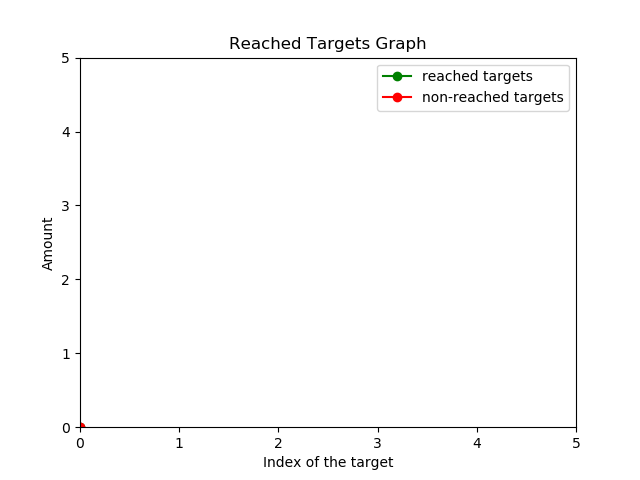

In [12]:
# Creating, displaying and animating the targets visualizer
targets_graph = TargetsGraph()
anim2 = FuncAnimation(targets_graph.fig, targets_graph.update_plot, init_func=targets_graph.plot_init)